In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ase.io
from ase import Atoms
from ase.visualize import view
from tabulate import tabulate

## Molecular Dynamics Simulation of Liquid Argon

In this section we will follow in the footsteps of Aneesur Rahman, who ran the first molecular dynamics computer simulation on liquid argon 60 years ago in 1964 [[1]](#1). Fittingly for this summer school, we will also be modelling the interactions between the Ar atoms with a Lennard Jones potential. This potential is given by:

$$U(r) = 4\epsilon [(\frac{\sigma}{r})^{12} -(\frac{\sigma}{r})^{6} ]$$

where $\sigma$ and $\epsilon$ are characteristic lengths and energies for a given system.

The values of $\sigma$ and $\epsilon$ for Argon are: $\sigma$ = 3.4 Å and $\epsilon/k_B = 120$ K, and the density at 94.4 K is 1374 kg/$\mathrm{m}^{-3}$.

Generally in simulations we use reduced Lennard Jones units, where $\sigma$, $\epsilon$ and $m$ are the units of length, energy and mass respectively; so our potential becomes:

$$U^{\star}(r^{\star}) = \frac{U(r)}{\epsilon} = U^{\star}(r^{\star}) = 4 [(\frac{1}{r*})^{12} -(\frac{1}{r*})^{6} ]$$

and for example density and temperature $\rho$ and $T$ become $\rho^{\star} = \rho \sigma^3$ and $T^{\star} = \frac{k_BT}{\epsilon}$ respectively.

**Qs:** Can you think of reason(s) why we would use reduced units?

- Reduced units make things easier from a practical perspective, since working in SI units can involve multiplying very large numbers, which can cause computational challenges with floating point multiplication.
- Using just $\sigma$, $\epsilon$ and $m$ determines a set of states for many systems with similar properties. In this way, as you can see in the next question, duplicate simulations do not need to be performed and instead the results can simply be scaled according to the system.

**Qs:** The Lennard-Jones parameters for Xenon are $\sigma = 3.96 Å $ and $\epsilon/k_B = 231.1 $ K. To what conditions of Xenon does our simulation of Argon correspond?

Here we can recognise that for a given state point of Argon, there is a corresponding state point of Argon:
$\rho^{\star}_{Ar} = \rho^{\star}_{Xe}$ and $T^{\star}_{Ar} = T^{\star}_{Xe}$

Therefore with $\sigma_{Ar}$ = 3.4 Å and $\epsilon_{Ar}/k_B = 120$ K, we get that $\rho_{Xe} = 870$ kg/$\mathrm{m}^{-3}$ and $T_{Xe} = 181.8$ K.

In the next cell so that you can get used to plotting with mathplotlib, plot the Lennard-Jones potential. 

Text(0, 0.5, 'U / ε')

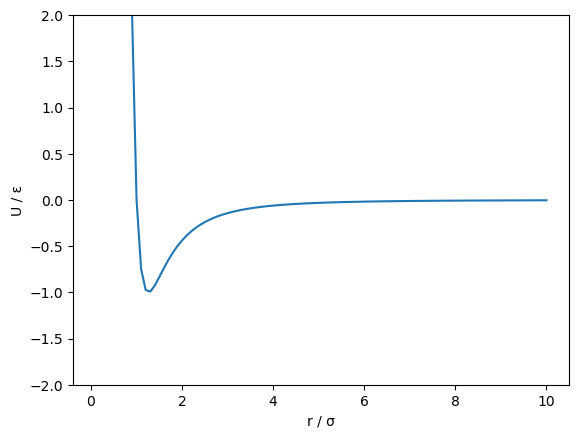

In [5]:
#Plot Lennard-Jones potential

x = np.linspace(0.1, 10, 100)
r2i = 1 / x
r6i = r2i**3
 
ecut = 0
y = 4 * r6i * (r6i - 1) - ecut
plt.plot(x,y)
plt.ylim(-2, 2)
plt.xlabel('r / σ')
plt.ylabel('U / ε')


**Qs:** What is the equation for the force between particles $i$ and $j$ interacting via this potential? You will need this expression later in the practical when implementing the MD code.

 (Remember that $f_{ij} = -\nabla U(r_{ij}$)

The force component in for example the $x$ direction between two particles separated by $r$ is:

$$f_x(r) = \frac{48}{r^2}\left(\frac{1}{r^{12}} - \frac{1}{2}\frac{1}{r^6}  \right)$$

Now we are ready to start writing our MD code. In general running an MD simulation consists of a sequence of steps 
1. Initialise the system with positions and velocities.
2. Compute forces.
3. Integrate Newton's Equations of Motion to get position after one timestep
4. Monitor properties

Steps 2 and 3 and 4 are repeated for a specified number of steps after which average properties (e.g. temperature) can be computed from the properties computed at each step in stage 4 (e.g. average temperature from instantaneous temperature). The resulting _trajectory_ - the positions of all the particles at each time can be analysed after to give properties such as the radial distribution function.

In the cell below you have been given a bare-bones MD code. While the general structure is in place, some key functions have been left out that you must fill in. Places that you should add your own code have been marked with ###

We will now work step-by-step through the code.

MD Code

In [6]:
#MD code

class MD:
    def __init__(self, n_particles, box_length, temperature, dt=0.005, read_positions=False):
        self.n_particles = n_particles
        self.box_length = box_length
        self.temperature = temperature
        self.dt = dt
        self.read_positions = read_positions
        self.positions, self.old_positions, self.velocities, self.U_kin = self.initialise_system(read_positions)
        # self.positions, self.old_positions, self.velocities, self.U_kin = self.initialise_system_random()

        self.forces, self.potential_energy, self.pressure = self.calculate_forces()



    def initialise_system(self, read_positions):

        if read_positions:
            positions = np.load('positions.npy')[-1] # load final frame of previous simulation as starting positions
        
        else:
            positions = np.zeros((self.n_particles, 3))

            n_per_dim = int(np.ceil(self.n_particles ** (1/3))) # n_particles should be a perfect cube

            # Calculate the spacing between particles
            spacing = self.box_length / n_per_dim

            counter = 0

            # Place particles on a lattice
            for i in range(n_per_dim):
                for j in range(n_per_dim):
                    for k in range(n_per_dim):
                        if counter < self.n_particles:
                            positions[counter] = np.array([i, j, k]) * spacing
                            counter += 1
        
        old_positions = np.zeros((self.n_particles, 3))
        velocities = np.zeros((self.n_particles, 3))

        # Initialize velocities with Maxwell-Boltzmann distribution
        velocities = np.random.normal(0, np.sqrt(self.temperature), (self.n_particles, 3))

        # Remove center of mass motion
        momentum = np.sum(velocities, axis=0) / self.n_particles
        velocities -= momentum

        # Rescale velocities to match desired temperature
        kinetic_energy = 0.5 * np.sum(velocities**2)
        scale_factor = np.sqrt((3 * self.n_particles * self.temperature) / (2 * kinetic_energy))
        velocities *= scale_factor

        # Get old positions for velocity verlet
        old_positions = positions - velocities * self.dt

        return positions, old_positions, velocities, kinetic_energy
    

    def calculate_forces(self):
        forces = np.zeros((self.n_particles, 3))
        potential_energy = 0.0
        pressure = 0.0
        
        cutoff = 0.5 * self.box_length 
        cutoff2 = cutoff ** 2
        ecut = 4 * (cutoff**-12 - cutoff**-6)  # Correct cutoff energy shift
        
        for i in range(self.n_particles):
            for j in range(i + 1, self.n_particles):
                xr = self.positions[i] - self.positions[j]
                # Periodic boundary conditions
                xr -= self.box_length * np.round(xr / self.box_length)
                r2 = np.dot(xr, xr)
                
                if r2 < cutoff2:  
                    r2i = 1.0 / r2
                    r6i = r2i ** 3
                    force_magnitude = 48 * r2i * r6i * (r6i - 0.5)  # LJ potential force magnitude
                    force = force_magnitude * xr
                    
                    forces[i] += force
                    forces[j] -= force
                
                    potential_energy += 4 * r6i * (r6i - 1) - ecut  # Shifted LJ potential
                    pressure += np.dot(force, xr)
        
        # Pressure normalization
        pressure /= (3.0 * self.box_length ** 3)
        
        return forces, potential_energy, pressure

   
    def euler(self):
        new_positions = self.positions + self.velocities * self.dt + 0.5 * self.forces * self.dt ** 2
        self.positions = new_positions
        new_velocities = self.velocities + 0.5 * self.forces * self.dt
        self.velocities = new_velocities

    def verlet(self):

        new_positions = np.zeros((self.n_particles, 3))
        new_positions = 2.0 * self.positions - self.old_positions + (self.forces * self.dt ** 2)
        self.velocities = (new_positions - self.old_positions) / (2.0 * self.dt)
        self.U_kin = 0.5 * np.sum(self.velocities**2)
        self.old_positions = self.positions
        self.positions = new_positions

    def velocity_verlet(self):
        # Half-step velocity update
        velocities_half = self.velocities + 0.5 * self.forces * self.dt
        
        # Full position update
        self.positions += velocities_half * self.dt
        
        # Recalculate forces based on the new positions
        self.forces, self.potential_energy, self.pressure = self.calculate_forces()
        
        # Full-step velocity update using the new forces
        self.velocities = velocities_half + 0.5 * self.forces * self.dt


    def calculate_temperature(self):
        # Calculate kinetic energy
        kinetic_energy = 0.5 * np.sum(self.velocities**2)
        # Calculate temperature
        temperature = (2 * kinetic_energy) / (3 * self.n_particles)
        return temperature

    def do_MD(self, n_steps, integrator):

        # Check if the integrator is valid
        if integrator not in ['euler', 'velocity_verlet']:
            raise ValueError("Must choose an integrator: 'euler' or 'velocity_verlet'")

        properties = np.zeros((n_steps, 5))
        positions = np.zeros((n_steps, self.n_particles, 3))

        for step in range(n_steps):
            self.forces, self.potential_energy, self.pressure = self.calculate_forces()
            
            if integrator == 'euler':
                self.euler()
            elif integrator == 'velocity_verlet':
                self.velocity_verlet()

            kinetic_energy = 0.5 * np.sum(self.velocities**2)
            total_energy = kinetic_energy + self.potential_energy
            temperature = self.calculate_temperature()

            properties[step] = np.array([step, kinetic_energy, self.potential_energy, total_energy, temperature])
            positions[step][:] = self.positions

            print(f"Step {step}, Kinetic Energy: {kinetic_energy:.3f}, Potential Energy: {self.potential_energy:.3f}, Total Energy: {total_energy:.3f}, Temperature: {temperature:.2f}")

        header = "# step kinetic_energy potential_energy total_energy temperature"
        np.savetxt('data.txt', properties, header=header, comments='', fmt='%.8f')
        np.save('positions.npy', positions)

        return positions, properties


### Step 1. Initialisation:
We will initialise the argon particles on a lattice, to give a reasonable starting configuration (_can you think what would happen for example if the atoms were intialised on top of or very close to each other?_). This is done with the ```initialise_system``` function of the MD class above.
So that your code runs reasonably quickly you should use 125 particles. Your first task is to calculate the **box size**, **temperature** and **timestep** you should use in your simulation in reduced units. Do this in a new cell underneath the MD code

Following from the definitions of the units of length, energy and mass being $\sigma$, $\epsilon$ and $m$, then the units of time $t^{\star}$ and temperature $T^{\star}$ become $\sigma \sqrt{m/\epsilon}$ and $\epsilon/kB$ respectively.

In [7]:
# Set Argon parameters
n_particles = 125
sigma_ar = 3.4E-10  # Lennard-Jones sigma for argon in meters
kb = 1.38064852E-23  # Boltzmann constant in J/K
epsilon_ar = 120 * kb  # Argon epsilon in J
mass_ar = 39.95 * 1.6747E-24  # Argon mass in grams
temperature = 94.4  # Argon temperature in K
density = 1.374 * 1E6  # In g/m^3
dt = 1E-14  # Time step in seconds
box_length = (mass_ar * n_particles / (density)) ** (1/3) #metres

box_length_lj = box_length / sigma_ar # In LJ units

temperature_lj = temperature * kb / epsilon_ar # In LJ units

dt_lj = dt / (sigma_ar * np.sqrt(mass_ar / epsilon_ar)) # In LJ units

n_particles = 125

table = [
    ["Number of particles", n_particles, "125"],
    ["Box length ", f"{box_length:.5e}", f"{box_length_lj:.5e}"],
    ["Temperature ", temperature, f"{temperature_lj:.5e}"],
    ["Time step ", f"{dt:.5e}", f"{dt_lj:.5e}"]
]

# Print the table
print(tabulate(table, headers=["Property", "SI Units", "LJ Units"], tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤═══════════════╕
│ Property            │      SI Units │      LJ Units │
╞═════════════════════╪═══════════════╪═══════════════╡
│ Number of particles │ 125           │ 125           │
├─────────────────────┼───────────────┼───────────────┤
│ Box length          │   1.82582e-09 │   5.37007     │
├─────────────────────┼───────────────┼───────────────┤
│ Temperature         │  94.4         │   0.786667    │
├─────────────────────┼───────────────┼───────────────┤
│ Time step           │   1e-14       │   0.000146361 │
╘═════════════════════╧═══════════════╧═══════════════╛


Now initialise the MD class with the number of particles, box length, temperature and timestep you have defined above.

In [8]:
md_simulation = MD(n_particles, box_length_lj, temperature_lj, dt_lj, read_positions = False)

A good practice is to visualise your initial condfiguration to ensure everything is as expected i.e. no overlapping particles etc. Here you can do this within the notebook with ASE. Note that ASE default units are A, and so you need to rescale your LJ distances back using $\sigma$.

In [9]:
system = Atoms(['Ar'] * md_simulation.n_particles, positions = md_simulation.positions * sigma_ar*1E10)
system.set_cell([box_length_lj * sigma_ar*1E10, box_length_lj * sigma_ar*1E10, box_length_lj * sigma_ar*1E10])
view(system, viewer = 'x3d')


## Step 2: Calculate forces

As you learned about in the lectures, so that we can mimic the simulation of an infinite bulk in our finite simulation cell, we employ periodic boundary conditions. You should implement this in the line under ```#periodic boundary conditions``` in the ```get_forces()``` function. 

You should also use the expression you computed for the forces above to implement the force calculation. You can see that the forces should be computed for all the pairs of particeles whose distance is less than the cutoff ```r_cut```.

Finally when you compute the potential energy you should remember to shift it such that the potential goes to 0 at the cutoff $r_c$:

$$ U^{sh}(r) = \begin{cases} U(r) - U(r_c) & \text{if } r < r_c \\ 0 & \text{if } r > r_c \end{cases} $$


## Step 3: Integrate Equations of Motion
Once you have computed the forces, the final step is to propegate the system according to Newton's Equations. There are many different numerical integration schemes for this, two of which you learned about in the lectures: _Simple Euler_ and _Velocity-Verlet_.

You should complete the functions ```euler``` and ```verlet``` in the code above. Note that when the system is initialised, ```old_positions```, ```new_positions``` and ```velocities``` are defined. You can update these simply by calling for example ```self.positions = new_positions```.

Recall that under the Euler Scheme, the positions are given by:
$$ r(t + \Delta t) = r(t) + v(t) \Delta(t) + \frac{1}{2} \frac{f(t)}{2m} \Delta t^2$$

while the Velocity-Verlet algorithm requires first to compute the velocities at $t+\Delta t/2$ so to update the positions at $t+\Delta t$, after which the velocities are then recomputed at $t+\Delta t$:

$$ p_i(t+\Delta t/2) = p_i (t) + \frac{1}{2}f_i(t)\Delta t \\
r_i(t + \Delta t) = r_i (t) + v_i (t+ \Delta t/2) \Delta t \\
p_i(t+ \Delta t) = p_i(t+\Delta t/2) + 1/2 f_i(t+\Delta t) \Delta t $$

## Step 4: Monitor Properties

The code will print out some properties of interest that you can monitor over the simulation [Timestep; kinetic energy; potential energy; total energy; temperature]. You should implement the code to compute the temperature at each step of the simulation ```calculate_temperature```. Recall that the temperature can be related to the average kinetic energy per degreee of freedom as $$\frac{1}{2}k_B T = \langle \frac{1}{2} m v^2 \rangle$$
You should therefore first compute the kinetic energy, and then relate that to the instantaneous temperature.

## Running the simulation
Your code should now be ready to run a simulation, which you can do in the cell below as shown:
You will notice that a number of properties are printed to the screen and saved to the variable `properties` [Timestep; kinetic energy; potential energy; total energy; temperature]. These properties are also saved to a file called ```data.txt```, which you can load and plot different properties over time (use numpy and matplotlib or else if you prefer gnuplot or some other plotting software).


In [10]:
n_steps = 100
# Run MD simulation
positions, properties_euler = md_simulation.do_MD(n_steps, integrator='euler')


Step 0, Kinetic Energy: 147.500, Potential Energy: -623.118, Total Energy: -475.618, Temperature: 0.79
Step 1, Kinetic Energy: 147.499, Potential Energy: -623.117, Total Energy: -475.618, Temperature: 0.79
Step 2, Kinetic Energy: 147.498, Potential Energy: -623.115, Total Energy: -475.617, Temperature: 0.79
Step 3, Kinetic Energy: 147.495, Potential Energy: -623.111, Total Energy: -475.616, Temperature: 0.79
Step 4, Kinetic Energy: 147.492, Potential Energy: -623.106, Total Energy: -475.613, Temperature: 0.79
Step 5, Kinetic Energy: 147.489, Potential Energy: -623.099, Total Energy: -475.610, Temperature: 0.79
Step 6, Kinetic Energy: 147.484, Potential Energy: -623.091, Total Energy: -475.607, Temperature: 0.79
Step 7, Kinetic Energy: 147.479, Potential Energy: -623.081, Total Energy: -475.602, Temperature: 0.79
Step 8, Kinetic Energy: 147.473, Potential Energy: -623.069, Total Energy: -475.597, Temperature: 0.79
Step 9, Kinetic Energy: 147.466, Potential Energy: -623.057, Total Energy

## Analysis of simulation 

The above simulation was run with the simple Euler method.

**Qs: ** Plot the total energy over time as shown below. What do you notice? Is the Euler scheme energy conserving?

**Qs: ** Repeat the same simulation again but this time using the Velocity-Verlet algorithm. Are there any differences compared to the Simple Euler method?

**Qs: ** What is the effect of the timestep on the stability of the simulation? Re-initialise the ```md_simulation``` object with different timesteps and make a plot of the potential energy over time.

In [11]:
positions, properties_verlet = md_simulation.do_MD(n_steps, integrator='velocity_verlet')

Step 0, Kinetic Energy: 143.593, Potential Energy: -615.381, Total Energy: -471.788, Temperature: 0.77
Step 1, Kinetic Energy: 143.439, Potential Energy: -615.227, Total Energy: -471.788, Temperature: 0.77
Step 2, Kinetic Energy: 143.283, Potential Energy: -615.071, Total Energy: -471.788, Temperature: 0.76
Step 3, Kinetic Energy: 143.126, Potential Energy: -614.914, Total Energy: -471.788, Temperature: 0.76
Step 4, Kinetic Energy: 142.967, Potential Energy: -614.755, Total Energy: -471.788, Temperature: 0.76
Step 5, Kinetic Energy: 142.807, Potential Energy: -614.595, Total Energy: -471.788, Temperature: 0.76
Step 6, Kinetic Energy: 142.645, Potential Energy: -614.433, Total Energy: -471.788, Temperature: 0.76
Step 7, Kinetic Energy: 142.482, Potential Energy: -614.270, Total Energy: -471.788, Temperature: 0.76
Step 8, Kinetic Energy: 142.317, Potential Energy: -614.105, Total Energy: -471.788, Temperature: 0.76
Step 9, Kinetic Energy: 142.151, Potential Energy: -613.939, Total Energy

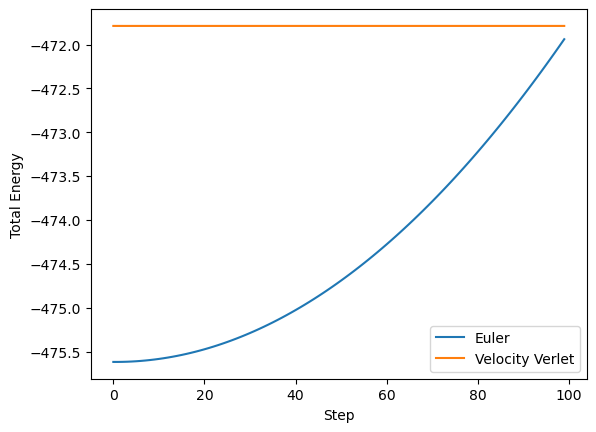

In [12]:
fig, ax = plt.subplots()
tot_energy = properties_euler[:,3]

ax.plot(np.arange(n_steps), tot_energy, label='Euler')
ax.ticklabel_format(style='plain')
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel('Step')
ax.set_ylabel('Total Energy')

tot_energy = properties_verlet[:,3]
ax.plot(np.arange(n_steps), tot_energy, label='Velocity Verlet')
ax.legend()

In [23]:
n_steps = 1000
md_simulation = MD(n_particles, box_length_lj, temperature_high, dt_lj, read_positions = False)
positions, properties_1 = md_simulation.do_MD(n_steps, integrator='velocity_verlet')

md_simulation = MD(n_particles, box_length_lj, temperature_high, dt_lj*10, read_positions = False)
positions, properties_10 = md_simulation.do_MD(n_steps, integrator='velocity_verlet')

md_simulation = MD(n_particles, box_length_lj, temperature_high, dt_lj*100, read_positions = False)
positions, properties_100 = md_simulation.do_MD(n_steps, integrator='velocity_verlet')


Step 0, Kinetic Energy: 294.998, Potential Energy: -623.116, Total Energy: -328.118, Temperature: 1.57
Step 1, Kinetic Energy: 294.994, Potential Energy: -623.112, Total Energy: -328.118, Temperature: 1.57
Step 2, Kinetic Energy: 294.986, Potential Energy: -623.104, Total Energy: -328.118, Temperature: 1.57
Step 3, Kinetic Energy: 294.975, Potential Energy: -623.093, Total Energy: -328.118, Temperature: 1.57
Step 4, Kinetic Energy: 294.961, Potential Energy: -623.079, Total Energy: -328.118, Temperature: 1.57
Step 5, Kinetic Energy: 294.944, Potential Energy: -623.062, Total Energy: -328.118, Temperature: 1.57
Step 6, Kinetic Energy: 294.924, Potential Energy: -623.042, Total Energy: -328.118, Temperature: 1.57
Step 7, Kinetic Energy: 294.901, Potential Energy: -623.019, Total Energy: -328.118, Temperature: 1.57
Step 8, Kinetic Energy: 294.875, Potential Energy: -622.993, Total Energy: -328.118, Temperature: 1.57
Step 9, Kinetic Energy: 294.845, Potential Energy: -622.963, Total Energy

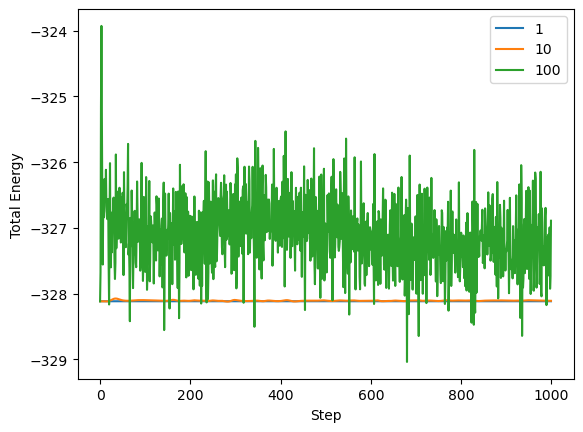

In [26]:
fig, ax = plt.subplots()
tot_energy1 = properties_1[:,3]
tot_energy10 = properties_10[:,3]
tot_energy100 = properties_100[:,3]


ax.plot(np.arange(n_steps), tot_energy1, label='1')
ax.plot(np.arange(n_steps), tot_energy10, label='10')
ax.plot(np.arange(n_steps), tot_energy100, label='100')

ax.ticklabel_format(style='plain')
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel('Step')
ax.set_ylabel('Total Energy')
ax.legend()


## Analysis of trajectory 

You will notice that the code also saves the _trajectory_ as ```positions.npy```, that is the positions of all particles at each timestep of the simulation. The trajectory is very rich in information and we can compute many different static and dynamic properties simply from the positions of the atoms. You can load the trajectory as shown in the notebook with ```np.load('positions.npy')```

You learned in the lectures about the radial distribution function $g(r)$ which probes the local structural properties:

$$g(r) = \frac{\langle N_p (r) \rangle}{N_p^{id}(r)} $$
where $\langle N_p (r) \rangle$ is the average number of particle pairs in a shell {r, r+\Deltar} and $N_p^{id}$ is the bulk number of pairs in the ideal gas.

**Qs:** In the cell below complete the function to compute the radial distribution function for a trajectory. The trajectory is loaded in the ```positions``` variable and the strucutre of the loops over the particles is there to get you started.

In [13]:
#radial distribution function

positions = np.load('positions.npy')

def get_rdf(positions, nbins=100):
    box_length = box_length_lj
    gr = np.zeros((nbins,2))
    dg = box_length / (2 * nbins)

    bin_index = 0
    for k in range(positions.shape[0]):
        for i in range(n_particles):
            for j in range(i+1, n_particles):
                rij = positions[k][i] - positions[k][j]
                rij -= box_length * np.round(rij / box_length) # periodic boundary conditions
                r = np.linalg.norm(rij)
                if r < box_length / 2:
                    bin_index = int(r / dg)
                    gr[bin_index][1] += 2
    
    for i in range(nbins): #final normalisation
        r = (i + 0.5) * dg
        v = (4 * np.pi / 3) * (n_particles / box_length**3) * dg**3 * ((i + 1) **3 - i**3)
        gr[i][1] /= (v * n_particles)
        gr[i][0] = r

    return gr

rdf = get_rdf(positions)

**QS:** Plot the radial distribution function as shown. Recall that the simulation was initialised on a lattice. Does the RDF show that the system has "melted"?

Text(0, 0.5, 'g(r)')

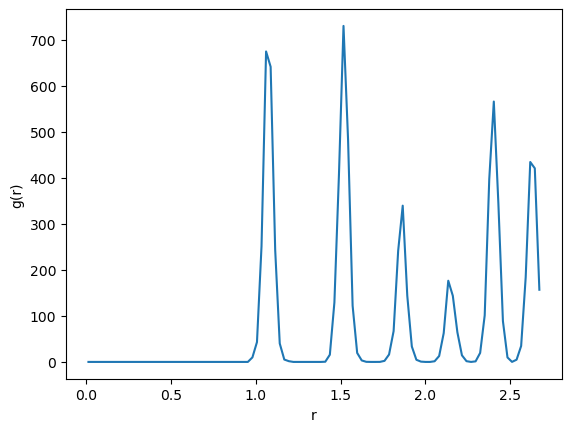

In [14]:
#plot radial distribution function

fig, ax = plt.subplots()
bins = rdf[:,0]
g = rdf[:,1]
ax.plot(bins  , g)   
ax.set_xlabel('r')
ax.set_ylabel('g(r)')


If your system is still looking very `solid-like' instead of waiting for a long time for it to melt, you could instead run a short (1000 steps) simluation at a higher temperature and then use the last frame to initialise a _production_ simulation at the target temperature. You can use the last frame of a saved trajectory by enabling ```read_positions=True``` in the initialisation. You should complete the code below with the correct ```temperature_high``` and ```temperature_target```.

**Qs:** Plot the rdf of the resulting simulation. You can also compare it to the rdf in Rahman's original paper.

In [17]:
temperature_high = temperature_lj * 2.0
n_steps = 1000

md_simulation = MD(n_particles, box_length_lj, temperature_high, dt_lj, read_positions = False)
positions, properties = md_simulation.do_MD(n_steps, integrator='velocity_verlet')



Step 0, Kinetic Energy: 294.998, Potential Energy: -623.116, Total Energy: -328.118, Temperature: 1.57
Step 1, Kinetic Energy: 294.994, Potential Energy: -623.112, Total Energy: -328.118, Temperature: 1.57
Step 2, Kinetic Energy: 294.986, Potential Energy: -623.104, Total Energy: -328.118, Temperature: 1.57
Step 3, Kinetic Energy: 294.976, Potential Energy: -623.094, Total Energy: -328.118, Temperature: 1.57
Step 4, Kinetic Energy: 294.962, Potential Energy: -623.080, Total Energy: -328.118, Temperature: 1.57
Step 5, Kinetic Energy: 294.945, Potential Energy: -623.063, Total Energy: -328.118, Temperature: 1.57
Step 6, Kinetic Energy: 294.926, Potential Energy: -623.044, Total Energy: -328.118, Temperature: 1.57
Step 7, Kinetic Energy: 294.903, Potential Energy: -623.021, Total Energy: -328.118, Temperature: 1.57
Step 8, Kinetic Energy: 294.877, Potential Energy: -622.995, Total Energy: -328.118, Temperature: 1.57
Step 9, Kinetic Energy: 294.848, Potential Energy: -622.966, Total Energy

Text(0, 0.5, 'g(r)')

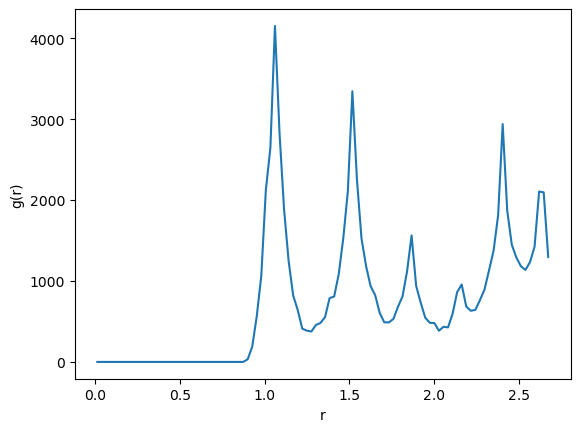

In [18]:
rdf = get_rdf(positions)
#plot radial distribution function

fig, ax = plt.subplots()
bins = rdf[:,0]
g = rdf[:,1]
ax.plot(bins  , g)   
ax.set_xlabel('r')
ax.set_ylabel('g(r)')

In [21]:
n_steps = 10000
temperature_target = temperature_lj
md_simulation = MD(n_particles, box_length_lj, temperature_target, dt_lj, read_positions = True)
positions, properties = md_simulation.do_MD(n_steps, integrator='velocity_verlet')


Step 0, Kinetic Energy: 147.520, Potential Energy: -634.550, Total Energy: -487.030, Temperature: 0.79
Step 1, Kinetic Energy: 147.540, Potential Energy: -634.570, Total Energy: -487.030, Temperature: 0.79
Step 2, Kinetic Energy: 147.560, Potential Energy: -634.590, Total Energy: -487.030, Temperature: 0.79
Step 3, Kinetic Energy: 147.580, Potential Energy: -634.609, Total Energy: -487.030, Temperature: 0.79
Step 4, Kinetic Energy: 147.599, Potential Energy: -634.629, Total Energy: -487.030, Temperature: 0.79
Step 5, Kinetic Energy: 147.619, Potential Energy: -634.648, Total Energy: -487.030, Temperature: 0.79
Step 6, Kinetic Energy: 147.638, Potential Energy: -634.668, Total Energy: -487.030, Temperature: 0.79
Step 7, Kinetic Energy: 147.657, Potential Energy: -634.687, Total Energy: -487.030, Temperature: 0.79
Step 8, Kinetic Energy: 147.677, Potential Energy: -634.706, Total Energy: -487.030, Temperature: 0.79
Step 9, Kinetic Energy: 147.696, Potential Energy: -634.725, Total Energy

Text(0, 0.5, 'g(r)')

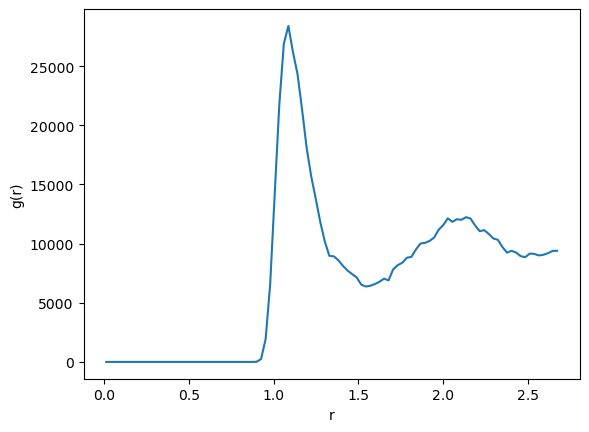

In [22]:
rdf = get_rdf(positions)
#plot radial distribution function

fig, ax = plt.subplots()
bins = rdf[:,0]
g = rdf[:,1]
ax.plot(bins  , g)   
ax.set_xlabel('r')
ax.set_ylabel('g(r)')

Finally you can save your trajectory as an `xyz` file, and use a visuliser such as ```VMD``` to view your trajectory.


In [32]:
positions = np.load('positions.npy')
for idx, i in enumerate(positions):
    system = Atoms(['Ar'] * md_simulation.n_particles, positions = i * sigma_ar*1E10)
    system.set_cell([box_length_lj * sigma_ar*1E10, box_length_lj * sigma_ar*1E10, box_length_lj * sigma_ar*1E10])
    if idx == 0:
        ase.io.write('argon.xyz', system, append = False)
    else:
        ase.io.write('argon.xyz', system, append = True)